In [2]:
# For version check
from platform import python_version
from importlib.metadata import version

In [3]:
import random

import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [4]:
print('Python: ', python_version())

print('numpy: ', version('numpy'))
print('pandas: ', pd.__version__)
print('seaborn: ', version('seaborn'))
print('matplotlib: ', version('matplotlib'))
print('scipy: ', version('scipy'))

Python:  3.10.1
numpy:  1.22.3
pandas:  1.4.2
seaborn:  0.11.2
matplotlib:  3.5.2
scipy:  1.8.1


In [43]:
plt.rcParams["figure.figsize"] = 13, 10
sns.set_style("whitegrid")

# 1. Random tree for BLAST ages

## 1.1. Create distribution

In [77]:
yeast_blast_ages = pd.read_csv('../data/04_genes_lists/yeast/yest_gene_ages.txt', 
                               sep='\t', 
                               header=None, 
                               names=['Tf', 'Age'])

yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')

In [78]:
yeast_blast_ages

,Tf,Age
0,YDL003W,Eukaryota
1,YKR060W,Opisthokonta
2,YMR254C,Saccharomyces
3,YEL059W,Saccharomyces
4,YHR030C,Eukaryota
...,...,...
4215,YKL037W,Saccharomyces
4216,YOR209C,Eukaryota
4217,YHR005C,Eukaryota
4218,YPR189W,Eukaryota


In [29]:
def random_ages_counter(df_ages, yeast_data, n=1000, classes=None):
    
    if classes == 'blast':
        classes = ['no info', 'Eukaryota', 'Opisthokonta', 'Ascomycota', 
                   'Saccharomycetaceae', 'Saccharomyces']
        
    elif classes == 'LProt':
        classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
                   'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

    else:
        classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 
                   'Dikarya', 'Ascomycota', 'Saccharomyceta', 'Saccharomycetaceae', 
                   'Saccharomyces']

    # transform names to numbers 
    df_ages['Age'] = df_ages['Age'].apply(lambda x: classes.index(x))
    
    # crerate df        
    counter = pd.DataFrame(np.nan, index=[i for i in range(len(classes)-1)], 
                           columns=[i for i in range(n)])
    
    for i in range(n):
        # shuffle
        df_ages =  df_ages.apply(lambda x: x.sample(frac=1, random_state=random.randint(0, 500)).values)
        
        
        # merge dataframes
        yeast_data['TF_age'] = yeast_data.merge(df_ages, how='left', on=['Tf']).Age        
        df_ages = df_ages.rename(columns = {'Tf':'Tg'})
        
        yeast_data['Tg_age'] = yeast_data.merge(df_ages, how='left', on=['Tg']).Age
        df_ages = df_ages.rename(columns = {'Tg':'Tf'})
        
        # calculate age distances
        yeast_data['age_length'] = np.where((yeast_data['TF_age'].isnull()) | (yeast_data['Tg_age'].isnull()),
                                         np.nan,
                                         abs(yeast_data['TF_age'] - yeast_data['Tg_age']))
        # add values to df
        counter[i] = pd.DataFrame(yeast_data['age_length'].value_counts(normalize=True) * 100)
            
    return counter.sort_index(ascending=True).T

In [80]:
counter = random_ages_counter(yeast_blast_ages, yeast_data, n=10000, classes='blast')

## 1.2. Test BLAST results

In [81]:
yeast_blast_ages = pd.read_csv('../data/04_genes_lists/yeast/yest_gene_ages.txt', 
                               sep='\t', 
                               header=None, 
                               names=['Tf', 'Age'])

yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')

In [82]:
# merge dataframes
yeast_data['Tf_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tf']).Age
yeast_blast_ages = yeast_blast_ages.rename(columns = {'Tf':'Tg'})
yeast_data['Tg_age'] = yeast_data.merge(yeast_blast_ages, how='left', on=['Tg']).Age
yeast_data[['Tg_age', 'Tf_age']] = yeast_data[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')
yeast_blast_ages = yeast_blast_ages.rename(columns = {'Tg':'Tf'})
        
# transform names to numbers
classes = ['no info', 'Eukaryota', 'Opisthokonta', 'Ascomycota', 'Saccharomycetaceae', 'Saccharomyces']
yeast_data['Tg_age_int'] = yeast_data['Tg_age'].apply(lambda x: classes.index(x))
yeast_data['TF_age_int'] = yeast_data['Tf_age'].apply(lambda x: classes.index(x))
yeast_data['age_length'] = np.where((yeast_data['TF_age_int'] == 0) | (yeast_data['Tg_age_int'] == 0),
                                    -1,
                                    abs(yeast_data['TF_age_int'] - yeast_data['Tg_age_int']))
# no info to NAN
yeast_data['age_length'] = yeast_data['age_length'].replace({-1: np.nan})

In [83]:
counts = pd.DataFrame(yeast_data['age_length'].value_counts(normalize=True) * 100)
counts = counts.rename(columns = {'age_length':'0'}).sort_index(ascending=True)

In [84]:
# blast_values
counts.T

,0.0,1.0,2.0,3.0,4.0
0,27.865224,17.314314,23.659616,8.116085,23.044761


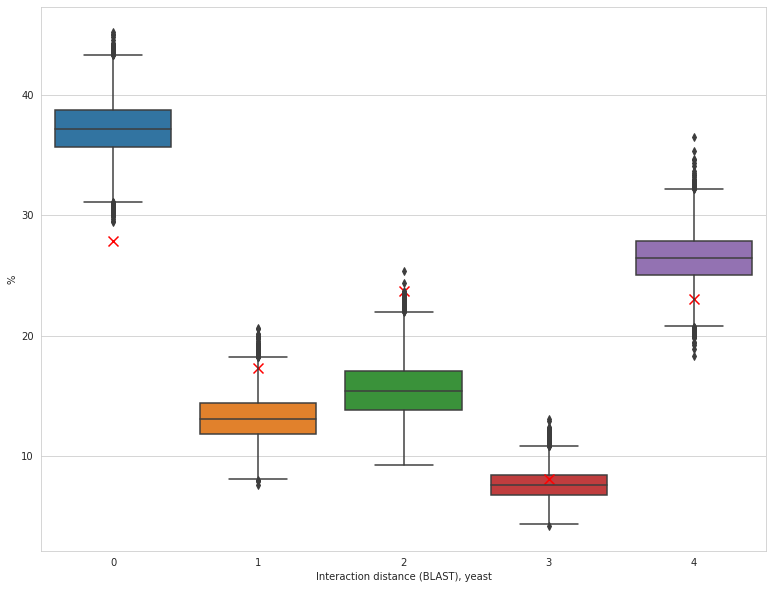

In [85]:
ax = sns.boxplot(data=counter)
ax.scatter(np.arange(counts.T.shape[1]), counts.T, 
           marker='x', s=100, color='r')

plt.ylabel('%')
plt.xlabel('Interaction distance (BLAST), yeast')
plt.show()

In [86]:
# mean and sd for distances
mean_blast = counter.mean()
sd_blast = counter.std()

print('BLAST:')

for i in range(counter.shape[1]):    
    z_score = (counts.loc[i][0] - mean_blast[i]) / sd_blast[i]
    n_sided = 2
    alpha = stats.norm.sf(abs(z_score)) * n_sided
    
    print(f'{i} distance, z-score: {round(z_score, 3)},\tp-value: {round(alpha, 4)} < 0.05 — {alpha < 0.05}')

BLAST:
0 distance, z-score: -4.108,	p-value: 0.0 < 0.05 — True
1 distance, z-score: 2.184,	p-value: 0.029 < 0.05 — True
2 distance, z-score: 3.433,	p-value: 0.0006 < 0.05 — True
3 distance, z-score: 0.397,	p-value: 0.6912 < 0.05 — False
4 distance, z-score: -1.619,	p-value: 0.1054 < 0.05 — False


In [87]:
mean_blast

0    37.195430
1    13.190493
2    15.502354
3     7.637968
4    26.473756
dtype: float64

# 2. Random tree for GenOrigin ages

## 2.1. Create distribution

In [6]:
yeast_GO_ages = pd.read_csv('../data/03_GenOrigin/yeast_gene_ages_GO.csv',
                            header=0,
                            names=['Tf', 'Age'])
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')
yeast_data_GO = pd.read_csv('../data/03_GenOrigin/yeast_classes_GO.csv')

In [90]:
counter_GO = random_ages_counter(yeast_GO_ages, yeast_data, n=10000)
counter_GO.head()

,0,1,2,3,4,5,6,7,8
0,14.346026,15.720199,19.172185,14.329470,11.630795,9.942053,5.695364,6.572848,2.591060
1,13.319536,18.153974,18.112583,14.089404,12.350993,9.470199,5.488411,6.829470,2.185430
2,13.807947,15.761589,17.706954,15.612583,12.524834,10.678808,4.842715,6.672185,2.392384
3,13.559603,19.594371,19.693709,13.551325,10.066225,9.900662,6.092715,5.016556,2.524834
4,14.072848,15.165563,16.018212,15.529801,10.347682,12.019868,4.942053,7.301325,4.602649


In [91]:
# transform names to numbers
classes = ['no info', '> Eukaryota', 'Eukaryota', 'Opisthokonta', 'Fungi', 'Dikarya', 'Ascomycota', 
           'Saccharomyceta', 'Saccharomycetaceae', 'Saccharomyces']

# Substituting nans with "no info"
yeast_data_GO[['Tg_age', 'Tf_age']] = yeast_data_GO[['Tg_age', 'Tf_age']].replace(np.nan, 'no info')

yeast_data_GO['Tg_age'] = yeast_data_GO['Tg_age'].apply(lambda x: classes.index(x))
yeast_data_GO['Tf_age'] = yeast_data_GO['Tf_age'].apply(lambda x: classes.index(x))

yeast_data_GO['age_length'] = np.where((yeast_data_GO['Tf_age'] == 0) | (yeast_data_GO['Tg_age'] == 0),
                                       -1,
                                       abs(yeast_data_GO['Tf_age'] - yeast_data_GO['Tg_age']))

# no info to NAN
yeast_data_GO['age_length'] = yeast_data_GO['age_length'].replace({-1: np.nan})

In [92]:
counts_GO = pd.DataFrame(yeast_data_GO['age_length'].value_counts(normalize=True) * 100)
counts_GO = counts_GO.rename(columns = {'age_length':'0'}).sort_index(ascending=True)

In [93]:
# GenOrigin
counts_GO.T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
0,14.254967,19.370861,21.407285,13.816225,9.817881,10.678808,5.852649,3.75,1.051325


## 2.2. Test GenOrigin results

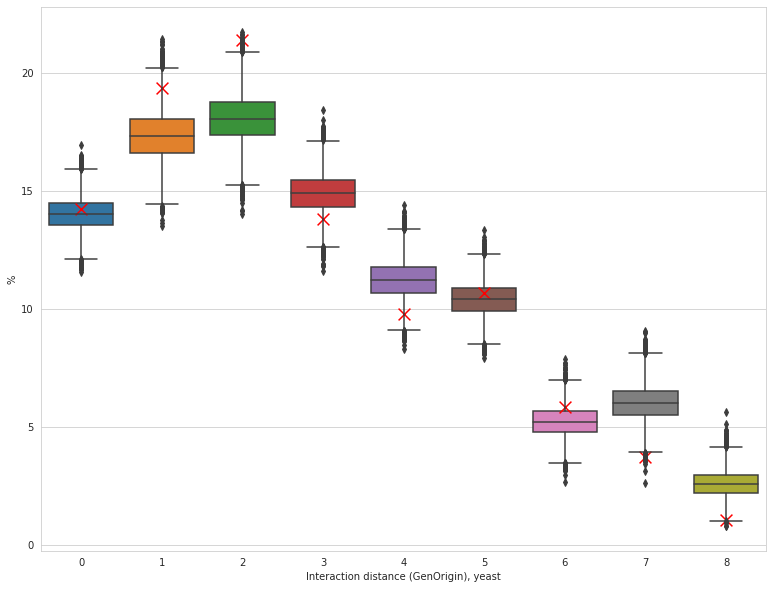

In [94]:
ax = sns.boxplot(data=counter_GO, )
ax.scatter(np.arange(counts_GO.T.shape[1]), counts_GO.T, 
           marker='x', s=140, color='r')

plt.ylabel('%')
plt.xlabel('Interaction distance (GenOrigin), yeast')
plt.show()

In [95]:
# mean and sd for distances
mean_GO = counter_GO.mean()
sd_GO = counter_GO.std()

print('GenOrigin:')

for i in range(counter_GO.shape[1]):    
    z_score = (counts_GO.loc[i][0] - mean_GO[i]) / sd_GO[i]
    n_sided = 2
    alpha = stats.norm.sf(abs(z_score)) * n_sided
    
    print(f'{i} distance, z-score: {round(z_score, 3)},\tp-value: {round(alpha, 4)} < 0.05 — {alpha < 0.05}')

GenOrigin:
0 distance, z-score: 0.293,	p-value: 0.7696 < 0.05 — False
1 distance, z-score: 1.865,	p-value: 0.0622 < 0.05 — False
2 distance, z-score: 3.132,	p-value: 0.0017 < 0.05 — True
3 distance, z-score: -1.318,	p-value: 0.1874 < 0.05 — False
4 distance, z-score: -1.774,	p-value: 0.0761 < 0.05 — False
5 distance, z-score: 0.363,	p-value: 0.7168 < 0.05 — False
6 distance, z-score: 0.937,	p-value: 0.3485 < 0.05 — False
7 distance, z-score: -2.959,	p-value: 0.0031 < 0.05 — True
8 distance, z-score: -2.702,	p-value: 0.0069 < 0.05 — True


In [96]:
mean_GO

0    14.047235
1    17.368724
2    18.085386
3    14.919918
4    11.252551
5    10.424902
6     5.244697
7     6.038365
8     2.618221
dtype: float64

# 3. Random tree for Protein ages
## 3.1. Create distribution

In [34]:
yeast_L_ages = pd.read_csv('../data/02_age_classes/yeast_gene_ages_L.csv',
                            header=0,
                            names=['Tf', 'Age'])
yeast_data = pd.read_csv('../data/01_GRNs/yeast.txt', sep='\t')
yeast_data_L = pd.read_csv('../data/02_age_classes/yeast_classes.csv')

In [35]:
counter_L = random_ages_counter(yeast_L_ages, yeast_data, n=10000, classes='LProt')
counter_L.head()

,0,1,2,3,4,5,6,7
0,24.506561,18.841353,13.826950,15.576656,14.979196,6.625413,1.611010,4.032860
1,20.975141,23.098261,15.832711,15.043209,13.997653,6.710765,1.675024,2.667236
2,26.587005,17.273018,12.930759,13.666916,18.627974,5.665209,1.952417,3.296703
3,20.004268,18.158540,14.413742,17.144991,15.277926,8.279100,1.514990,5.206444
4,19.993599,18.467940,15.341940,16.440841,16.206124,6.710765,2.624560,4.214232


In [37]:
yeast_data_L

,Tf,Tg,TF_age,Tg_age
0,YAL051W,YAL016W,Saccharomyceta,Eukaryota
1,YAL051W,YAL034WA,Saccharomyceta,NaN
2,YAL051W,YAL035CA,Saccharomyceta,NaN
3,YAL051W,YAL035W,Saccharomyceta,Euk_Archaea
4,YAL051W,YAL036C,Saccharomyceta,Cellular_organisms
...,...,...,...,...
12868,YPR199C,YML048WA,NaN,NaN
12869,YPR199C,YMR086CA,NaN,NaN
12870,YPR199C,YMR087W,NaN,Saccharomyceta
12871,YPR199C,YMR135WA,NaN,NaN


In [38]:
# transform names to numbers
classes = ['no info', 'Cellular_organisms', 'Euk_Archaea','Euk+Bac', 'Eukaryota',
                   'Opisthokonta', 'Dikarya', 'Ascomycota', 'Saccharomyceta']

# Substituting nans with "no info"
yeast_data_L[['Tg_age', 'TF_age']] = yeast_data_L[['Tg_age', 'TF_age']].replace(np.nan, 'no info')

yeast_data_L['Tg_age'] = yeast_data_L['Tg_age'].apply(lambda x: classes.index(x))
yeast_data_L['TF_age'] = yeast_data_L['TF_age'].apply(lambda x: classes.index(x))

yeast_data_L['age_length'] = np.where((yeast_data_L['TF_age'] == 0) | (yeast_data_L['Tg_age'] == 0),
                                       -1,
                                       abs(yeast_data_L['TF_age'] - yeast_data_L['Tg_age']))

# no info to NAN
yeast_data_L['age_length'] = yeast_data_L['age_length'].replace({-1: np.nan})

In [39]:
counts_L = pd.DataFrame(yeast_data_L['age_length'].value_counts(normalize=True) * 100)
counts_L = counts_L.rename(columns = {'age_length':'0'}).sort_index(ascending=True)

In [40]:
# GenOrigin
counts_L.T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,14.701803,17.977168,18.531953,13.602902,20.174971,8.407127,1.632348,4.971727


## 3.2. Test  results

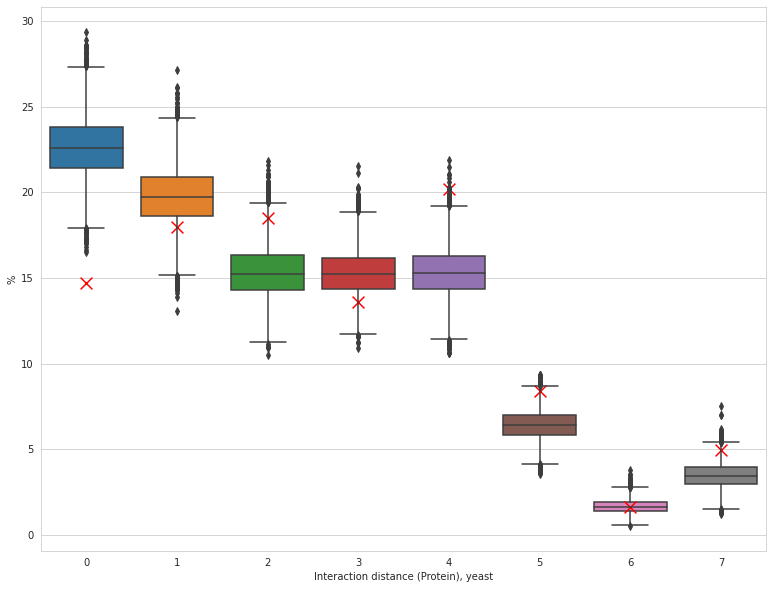

In [44]:
ax = sns.boxplot(data=counter_L, )
ax.scatter(np.arange(counts_L.T.shape[1]), counts_L.T, 
           marker='x', s=140, color='r')

plt.ylabel('%')
plt.xlabel('Interaction distance (Protein), yeast')
plt.show()

In [45]:
# mean and sd for distances
mean_L = counter_L.mean()
sd_L = counter_L.std()

print('GenOrigin:')

for i in range(counter_L.shape[1]):    
    z_score = (counts_L.loc[i][0] - mean_L[i]) / sd_L[i]
    n_sided = 2
    alpha = stats.norm.sf(abs(z_score)) * n_sided
    
    print(f'{i} distance, z-score: {round(z_score, 3)},\tp-value: {round(alpha, 4)} < 0.05 — {alpha < 0.05}')

GenOrigin:
0 distance, z-score: -4.579,	p-value: 0.0 < 0.05 — True
1 distance, z-score: -1.045,	p-value: 0.2959 < 0.05 — False
2 distance, z-score: 2.078,	p-value: 0.0377 < 0.05 — True
3 distance, z-score: -1.296,	p-value: 0.1951 < 0.05 — False
4 distance, z-score: 3.335,	p-value: 0.0009 < 0.05 — True
5 distance, z-score: 2.343,	p-value: 0.0191 < 0.05 — True
6 distance, z-score: -0.115,	p-value: 0.9082 < 0.05 — False
7 distance, z-score: 2.064,	p-value: 0.039 < 0.05 — True


In [46]:
mean_L

0    22.629517
1    19.761616
2    15.349728
3    15.306517
4    15.342950
5     6.440203
6     1.681060
7     3.488409
dtype: float64